# Obligatorio de Analisis Predictivo de Series Temporales


## Predicción del Bitcoin

## Estudiantes: Marcelo Guelfi, Alfredo Rodríguez


## 1. Presentación de la serie

#### Instalación de los paquetes requeridos

In [2]:
# lista de paquetes requeridos
required_pkgs <- c('tidyverse'      , 'ggtext'    , 'rugarch', 
                   'BatchGetSymbols', 'GetBCBData', 'cowplot', 
                   'purrr'          , 'tidyr'     , 'FinTS'  , 
                   'scales'         , 'texreg'    , 'knitr'  , 
                   'kableExtra'     , 'forecast'  , 'writexl',
                   'astsa'          , 'tydiverse' , 'lubridate',
                   'xts'            , 'keras'     , 'tidyquant',
                   'quantmod'       , 'MTS')


# verificación de paquetes instalados
installed_pkgs <- installed.packages()

# verificación de paquetes a instalar
missing_pkgs <- required_pkgs[!(required_pkgs %in% installed_pkgs[, 1])]

if (length(missing_pkgs) == 0 ) {
  message("No missing dependencies")
} else {
  install.packages(missing_pkgs)
  
  message("All packages installed")
  
}

options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas


Warning message:
“package ‘tydiverse’ is not available (for R version 3.6.3)”
also installing the dependencies ‘systemfonts’, ‘svglite’, ‘alphavantager’, ‘timetk’


Warning message in install.packages(missing_pkgs):
“installation of package ‘systemfonts’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘timetk’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘svglite’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘alphavantager’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘kableExtra’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘tidyquant’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

All packages installed



#### Importación de datos

In [1]:
# Importación data Bitcoin-USD de Yahoo Finance.
# El dataset resultante es serializdo y salvado en un archivo rds "data/BTC-GARCH-Data.rds". 
# luego este dataset será divido en entrenamiento y test

library(BatchGetSymbols)
library(tidyverse)

first_date <- as.Date("2017-07-15",format="%Y-%m-%d") # first date in sample ("2013-04-28" es la primer fecha con datos en Yahoo Finance)
last_date <- as.Date('2021-07-27', format="%Y-%m-%d") # set Sys.Date() for current date 
train_date <- as.Date('2021-01-27', format="%Y-%m-%d") # set Sys.Date() for current date 
my_ticker <- 'BTC-USD'
series_name <- 'BTC-USD' # Name of index/stock that will show up in all plots

l_out <- BatchGetSymbols(tickers = my_ticker, 
                         first.date = first_date, 
                         last.date = last_date)

# select columns and calculated log_ret and arim_ret
df_prices <- l_out$df.tickers %>%
  select(ref.date, ticker, price.adjusted) %>%
  mutate(log_ret = log(price.adjusted/dplyr::lag(price.adjusted) ),
         arim_ret = price.adjusted/dplyr::lag(price.adjusted) - 1,
         series_name = series_name) %>%
  na.omit() # remove all NA values

# guarda los datos en un archivo rds
rds_out <- 'data/BTC-GARCH-Data.rds'
write_rds(df_prices, rds_out)


Loading required package: rvest

Loading required package: xml2

Loading required package: dplyr

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──

✔ ggplot2 3.3.2     ✔ readr   1.3.1
✔ tibble  3.0.3     ✔ purrr   0.3.4
✔ tidyr   1.1.0     ✔ stringr 1.4.0
✔ ggplot2 3.3.2     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()         masks stats::filter()
✖ readr::guess_encoding() masks rvest::guess_encoding()
✖ dplyr::lag()            masks stats::lag()
✖ purrr::pluck()          masks rvest::pluck()


Running BatchGetSymbols for:

   tickers =BTC-USD


^GSPC | yahoo (1|1)
 | Not Cach

Se optó por usar los valores diarios, debido a que son los más usado en estudios de volatilidad y pare evitar el ruido de datos de alta frecuencia.

#### Gráficas

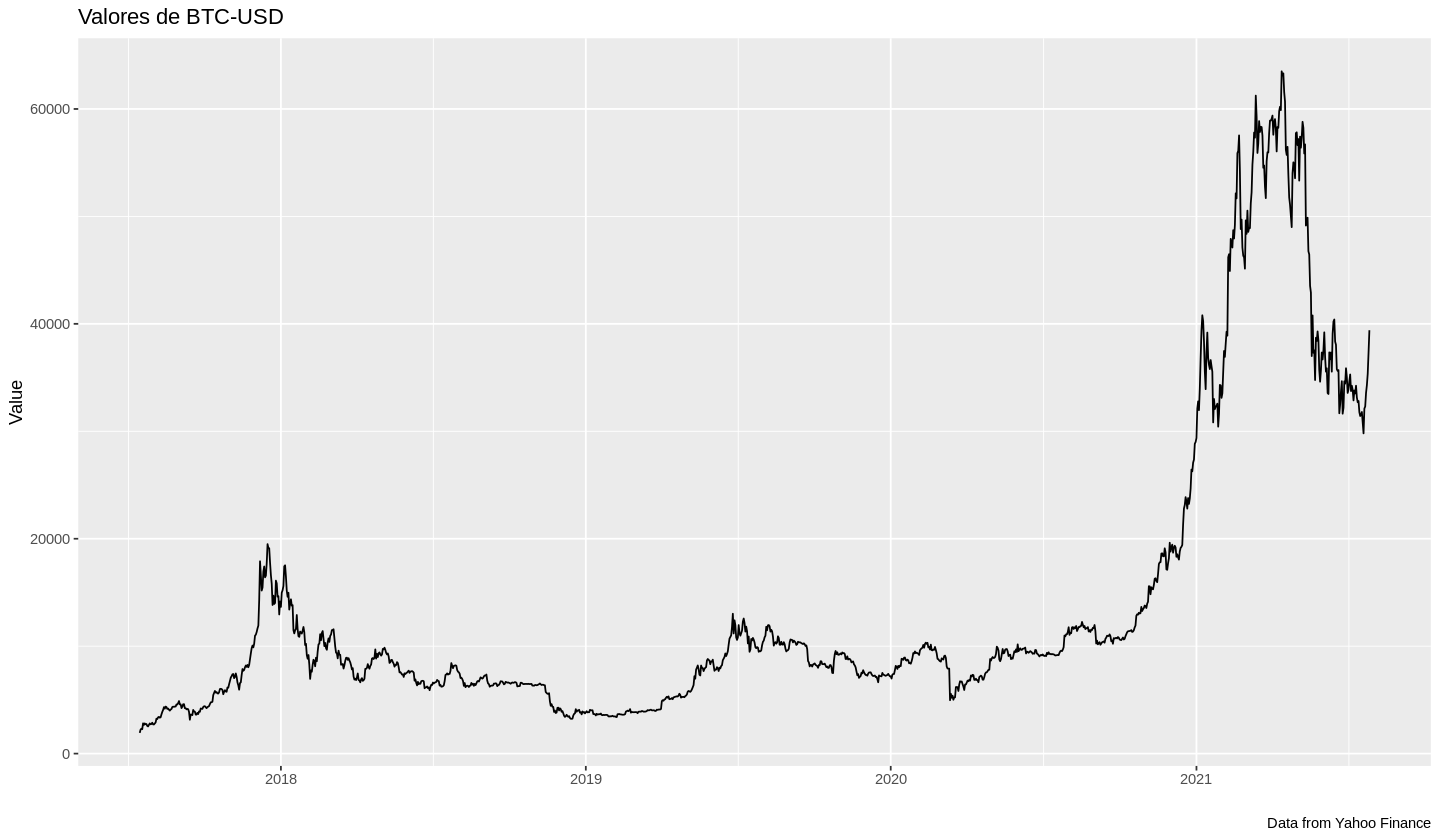

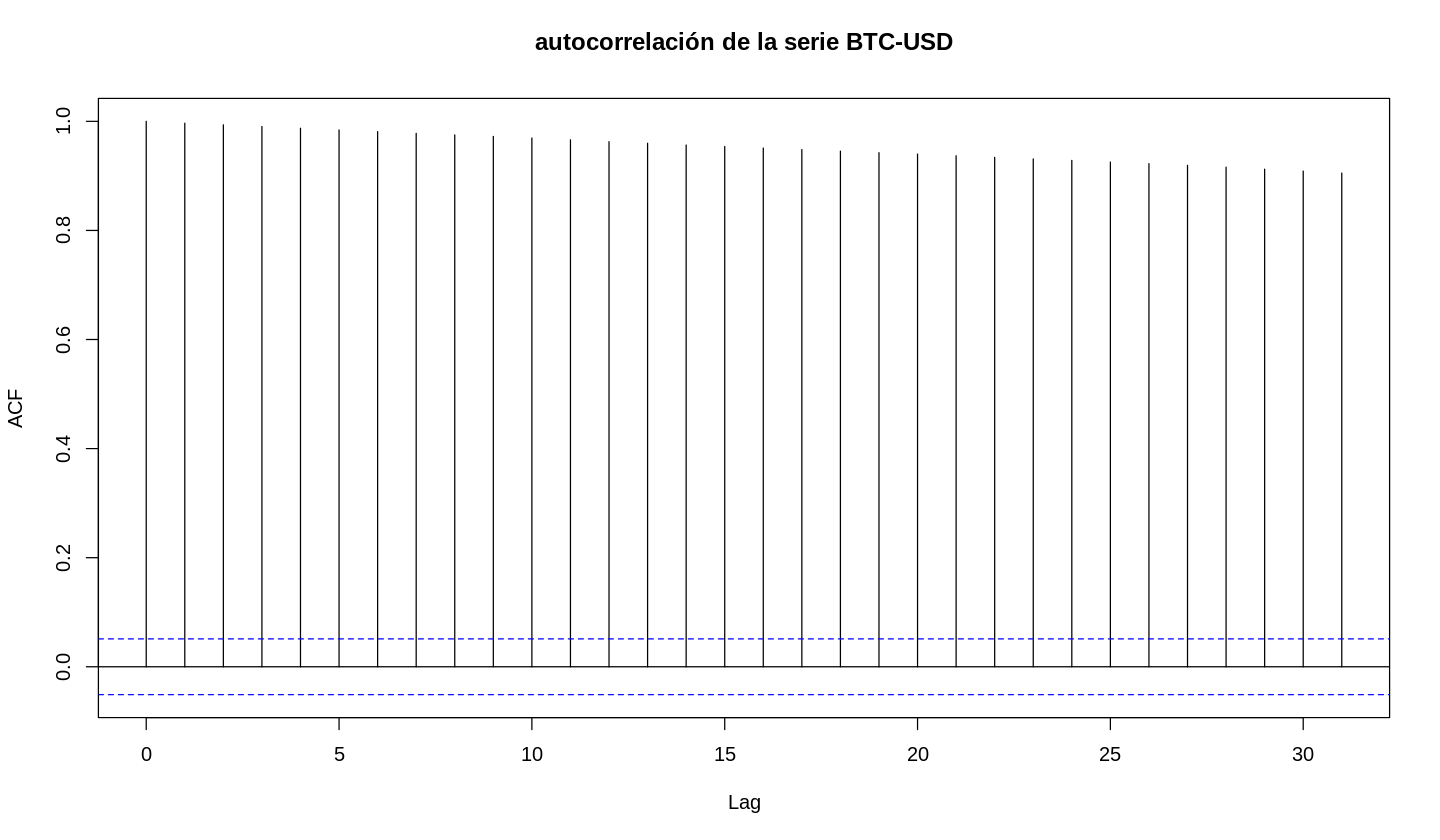

In [3]:
# carga de librerías
library(cowplot)
library(tidyverse)
library(GetBCBData)

# close all existing plot windows
#graphics.off()

# carpeta "figs" para guardar diagramas
if (!dir.exists('figs')) dir.create('figs')

# script con funciones base
source('fcts/garch_fcts.R')

# obtención de los datos
df_prices <- read_rds('data/BTC-GARCH-Data.rds')  #guarda los datos en archivo rds
series_name <- df_prices$series_name[1]

# gráfica con los valores de BTC-USD
p1 = ggplot(df_prices, aes(x = ref.date, y = price.adjusted)) + 
  geom_line() + 
  labs(title = paste0('Valores de ', series_name),
       x = '',
       y = 'Value',
       caption = 'Data from Yahoo Finance') 
  
p1

#acf de la serie para comprobar que no es estacionaria
acf(df_prices$price.adjusted, main='autocorrelación de la serie BTC-USD')

Se ve claramente que la serie no es estacionaria

## 2. Análisis exploratorio
Transformaciones, búsqueda de tendencias o ciclos. Estacionarizacion.

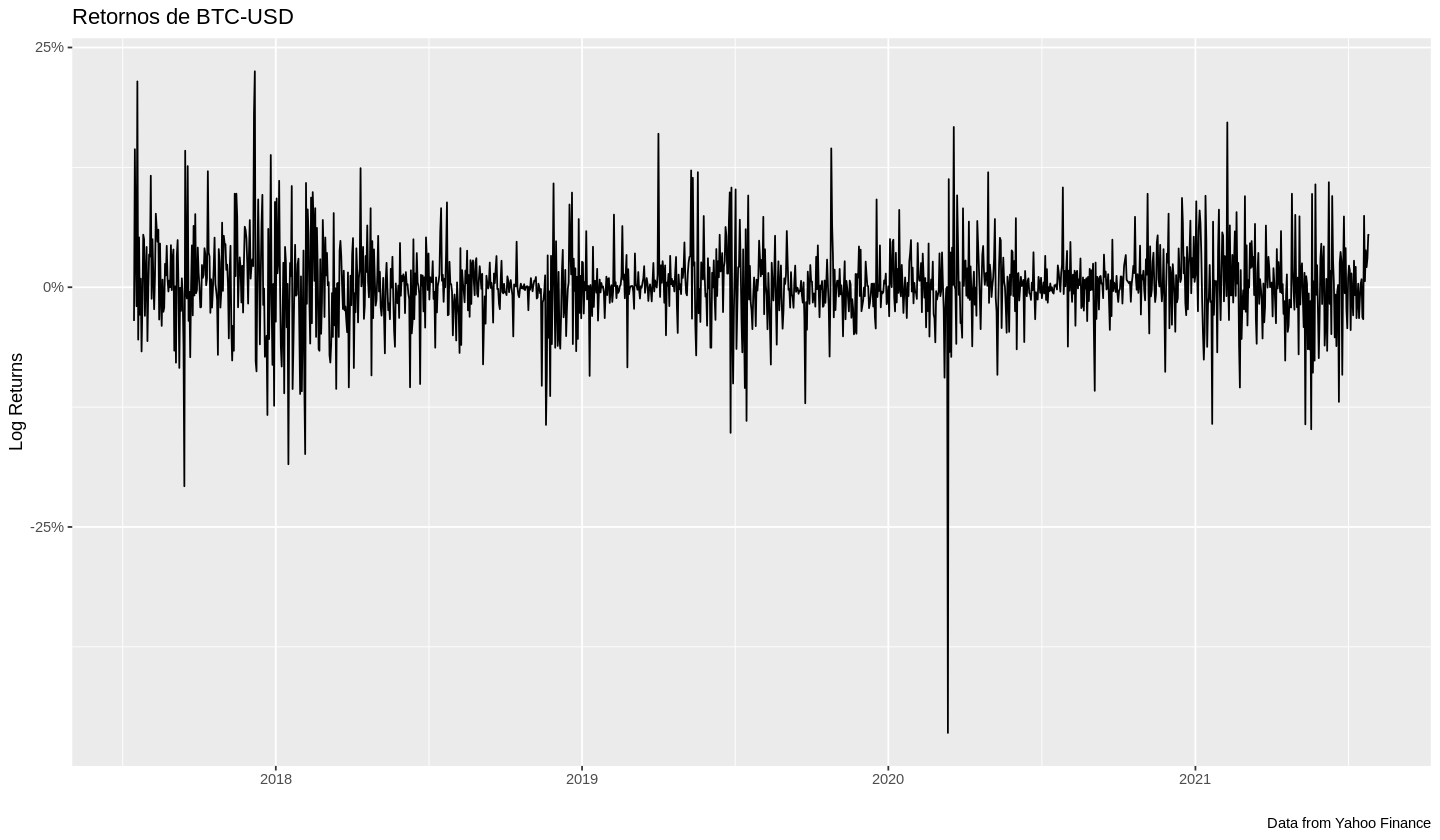

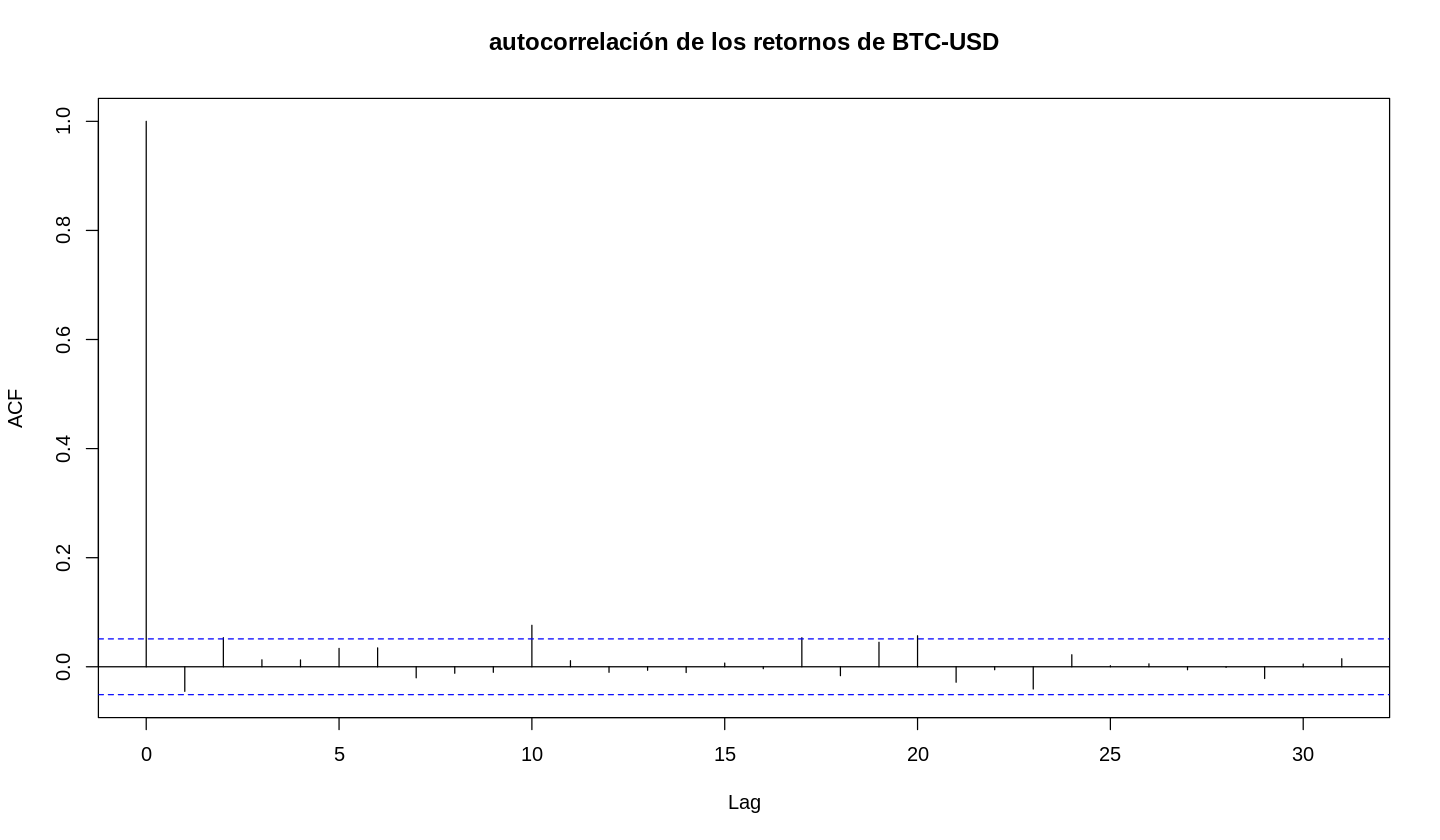

In [4]:
# gráfica de retornos
p2 = ggplot(df_prices, 
             aes(x = ref.date, y = log_ret)) + 
  geom_line() + 
  labs(title = paste0('Retornos de ', series_name),
       x = '',
       y = 'Log Returns',
       caption = 'Data from Yahoo Finance') + 
  scale_y_continuous(labels = scales::percent) + 
  scale_color_brewer(palette = 'BrBG')

p2

#acf de la serie para comprobar que es estacionaria

acf(df_prices$log_ret, main='autocorrelación de los retornos de BTC-USD')

Se usa el retorno logarítmico debido a sus propiedades de estacionalidad y ergodicidad (esto implica que un proceso aletorio no cambiará sus características estadísticas con el tiempo y que además pueden ser deducidas a partir de una muestra suficientemente grande).
La mayoría de los retornos están centrados alrededor de cero, y los grandes cambios de valor tienden a ocurrir en un período corto. Esto se denomina volatility clustering. 
Por otro lado se ve qué la volatilidad no es constante (heterocedasticidad). Este problema es el que atacan los modelos ARCH y GARCH.
La volatilidad se define como $\sigma_{t}$, donde $\sigma_{t}^2$ es la varianza de la serie de retornos.
En cuanto a la ACF, en retornos financieros, se espera tener baja autocorrelación, debido que los retornos pasados no pueden explicar retornos futuros.
En series con heterocedasticidad, se puede calcular la media con una regresión de mínimos cuadrados con ARMA, pero los SE y los intervalos de confianza estimados serán muy pequeños, dando una falsa sensación de exactitud.
Los modelos ARCH y GARCH no solo corrigen las deficiencias de la regresión de mínimos cuadrados, sino que también predicen la varianza.

Un modelo ARCH(m) establece que la varianza condicional es función de los retornos pasados:
\begin{equation}
  \begin{aligned}
     r_{t}         &= \sigma_{t} \epsilon_{t} \\ 
     \sigma_{t}^2    &= \alpha_{0} + \alpha_{1} r_{t-1}^2 + ... +\alpha_{q} r_{t-m}^2 
       \label{eqn:example} 
  \end{aligned}
\end{equation}

Donde $r_{t}$ son los retornos en el tiempo "t" (residuos de un ajuste regresivo de media, modelado como un proceso de ruido blanco), $\sigma_{t}^2$ es la varianza condicional en el tiempo "t", $\alpha_{q}$ son los diferentes parámetros del modelo ARCH a ser estimados, y $\epsilon_{t}$ es una secuencia de variables aleatorias independientes e idénticamente distribuídas con media cero y varianza 1.
Por tanto, el modelo ARCH modela la varianza en un tiempo "t" como función de los residuos del proceso de ajuste de media.


En el modelo GARCH(p,q) se establece que la varianza condicional es función de los retornos pasados y también de las varianzas pasadas:
\begin{equation}
  \begin{aligned}
    r_{t}         &= \sigma_{t} \epsilon_{t} \\ 
    \sigma_{t}^2    &= \alpha_{0} + \sum_{i=1}^q \alpha_{i} r_{t-1}^2 + \sum_{i=1}^p \beta_{i} \sigma_{t-i}^2 
      \label{eqn:example} 
  \end{aligned}
\end{equation}

Una posible crítica a los modelos ARCH/GARCH, es que al ser la varianza condicional una función lineal del cuadrado de las innovaciones pasadas, implica una simetría en el efecto, donde una cambio positivo afecta a la volatilidad de la misma forma que un cambio negativo.
Los modelos EGARCH y GJR-GARCH permiten los efectos asimétricos, siguiendo la idea que la volatilidad puede subir en respuesta a malas noticias y puede bajar frente a buena noticia.
El EGARCH y GJR-GACRH toman en cuenta el comportamiento asimétrico con el coeficiente $\delta_{i}$.
Un valor significativo de $\delta_{i}$ indica que cuando hay malas noticias en el mercado, los retornos son negativos pero la volatilidad aumenta.

ARCH Test de Engle.
El Test veifica que $r_{t}$ no presenta efectos ARCH
Se verifica por la hipótesis nula

In [ ]:
library(MTS)
archTest(df_prices$log_ret)

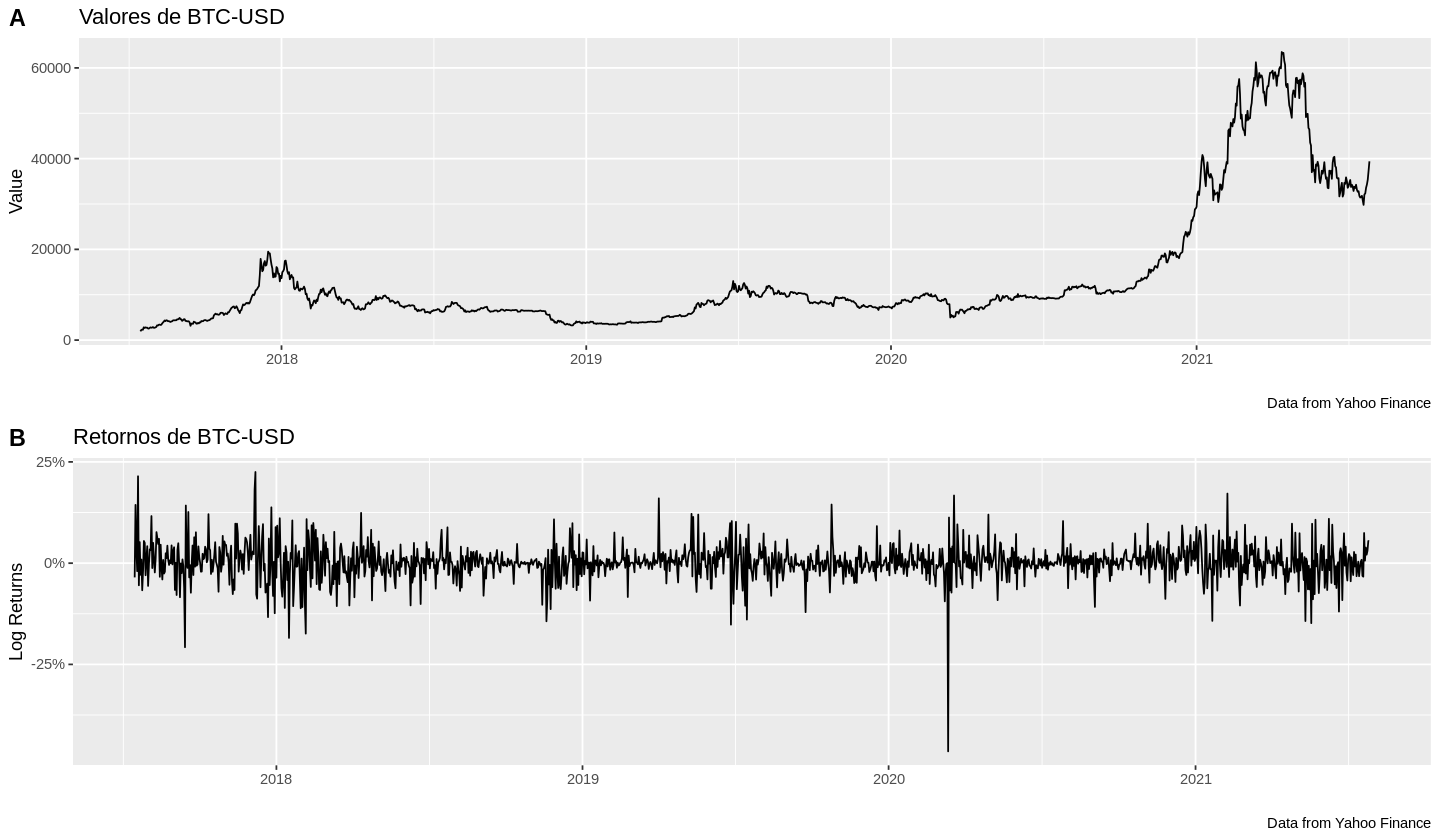

In [5]:
# grafica ambos plots

plot_grid(p1, p2, nrow = 2, 
               labels = 'AUTO')

## 3. Modelos Estadísticos

Paquetes GARCH disponibles:Los paquetes actualmente mantenidos con fGARCH y RUGARCH, se optó por el 2do que tiene más opciones y modelos.

Para estimar los órdenes del ajuste ARMA se hacer el ACF y PACF de los retornos

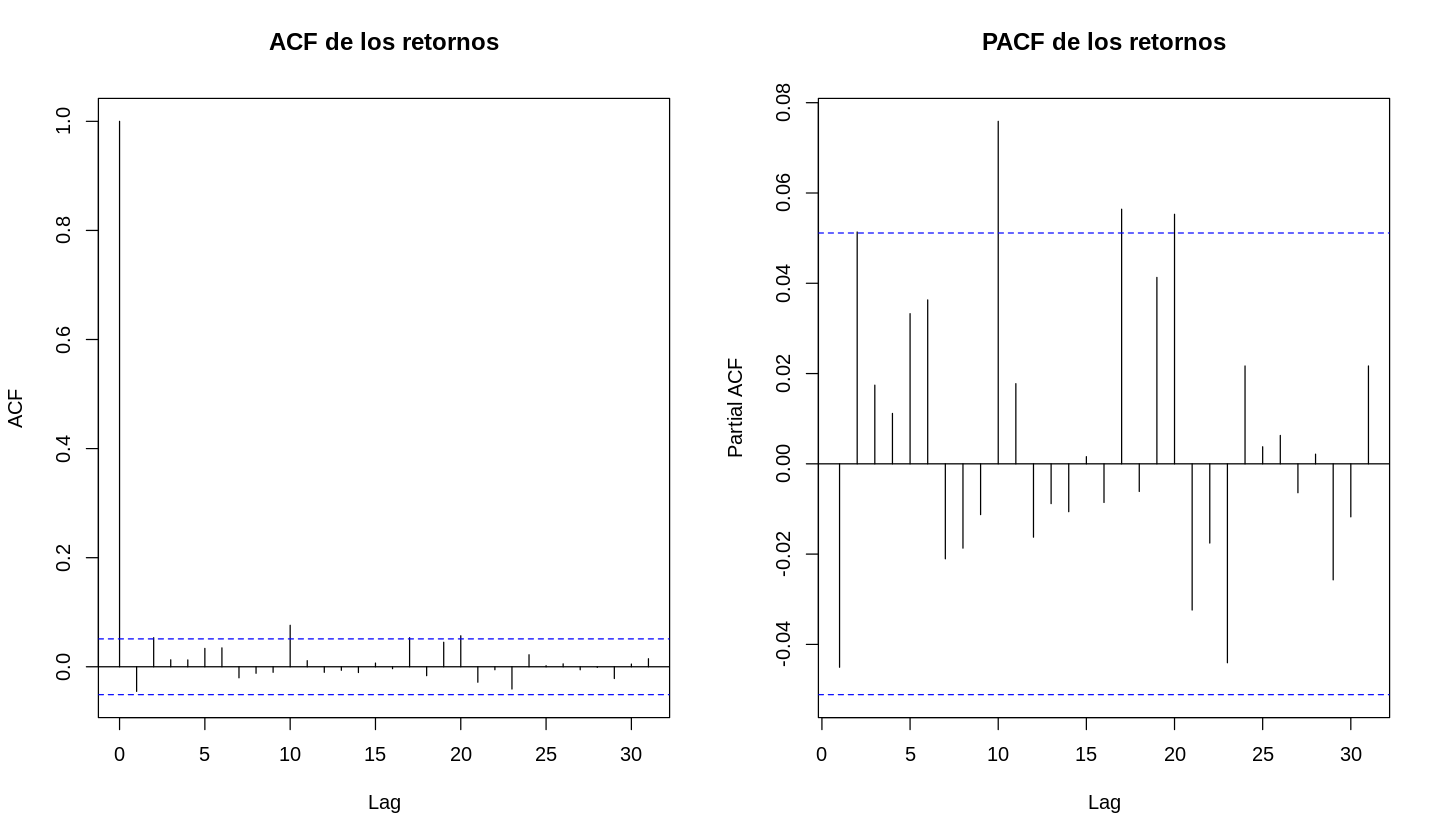

In [6]:
par(mfrow=c(1,2))
acf(df_prices$log_ret, main='ACF de los retornos')
pacf(df_prices$log_ret, main='PACF de los retornos')

Se hacen los analisis de ACF y PACF de $r_{t}^2$ para ver los coeficientes del ajuste GARCH, dado que el orden del ARMA es 0 y que $r_{t}$ ya es ruido blanco. Es decir, que el $r_{t}$ se puede considerar como el residuo de un proceso regresivo de ajuste de media y $r_{t}^2$ puede considerarse como un proxy de $\sigma_{t}^2$

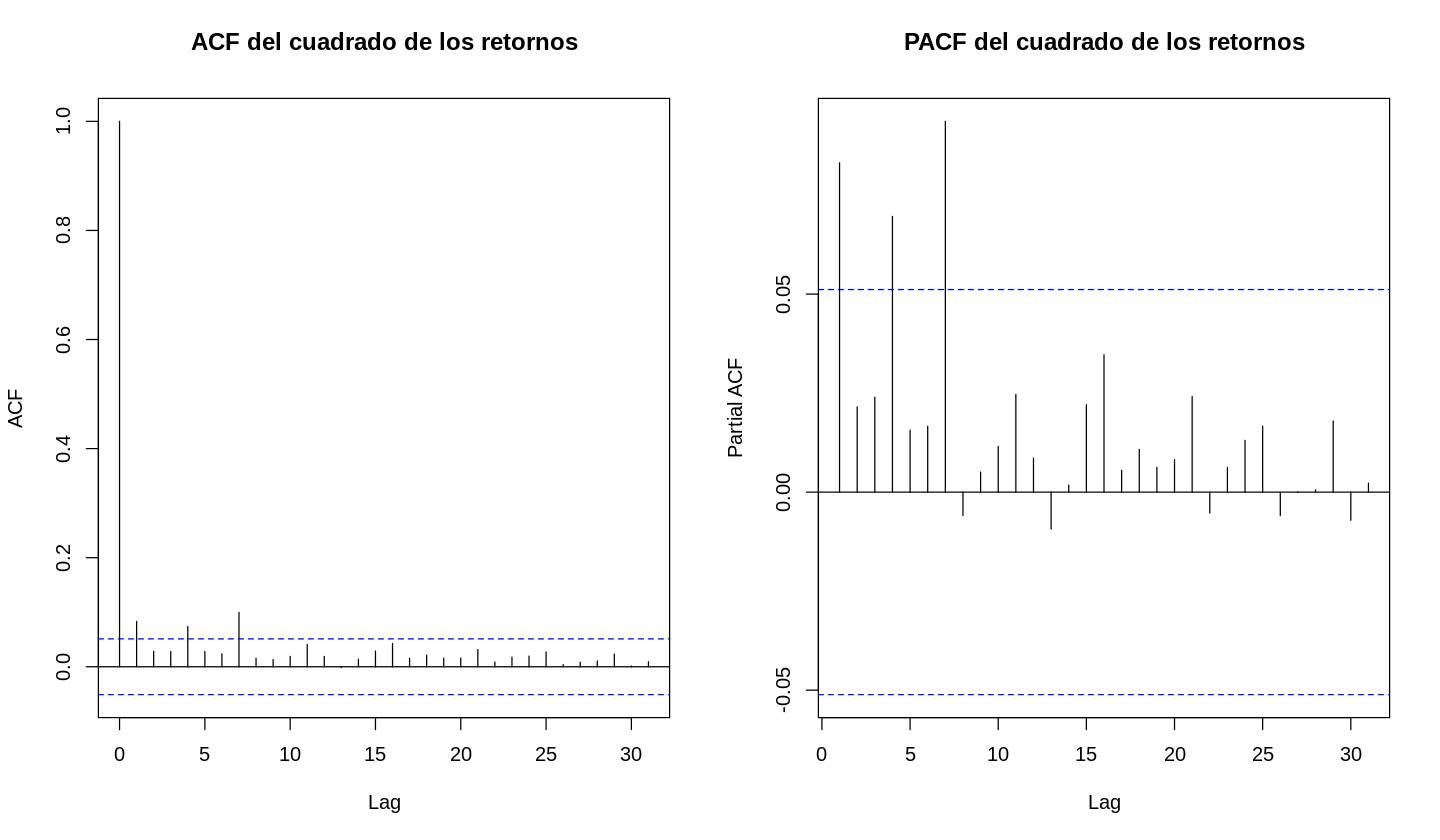

In [7]:
par(mfrow=c(1,2))
acf((df_prices$log_ret)^2, main='ACF del cuadrado de los retornos')  # da el "q"
pacf((df_prices$log_ret)^2, main='PACF del cuadrado de los retornos') # da el "p"

#### Estimación de modelos GARCH

Se realizaron las estimaciones con 3 tipos de modelos GARCH, con igual número de lags y 3 distribuciones diferentes.
Solamente se dejó un coeficiente constante para la media (sin coeficientes ARMA) y lag=1 para cada uno de los modelos de volatilidad (verificado por los ACF y PACF de los cuadrados de los retornos y aplicando el principio de parsimonia).

In [8]:
# Se estiman tres modelos simples de GARCH con 3 distribuciones 
# se guarda el resultado de la comparación en un archivo html
# se estima en train para después evaluar la predicción para test

ar_lag <- 0 # lag usado para el término AR de la media 
ma_lag <- 0 # lag usado para el término MA de la media 
arch_lag <- 1 # lag para el efecto ARCH (es el "q")
garch_lag <- 1 # lag para el efecto GARCH (es el "p")
models_to_estimate <- c('sGARCH', 'eGARCH', 'gjrGARCH') 
# model Valid models (currently implemented) are “sGARCH”, “fGARCH”, “eGARCH”, “gjrGARCH”, “apARCH” and “iGARCH” 
# and “csGARCH”. submodel If the model is “fGARCH”, valid submodels are “GARCH”, “TGARCH”, “AVGARCH”, “NGARCH”, 
# “NAGARCH”, “APARCH”,“GJRGARCH” and “ALLGARCH”. 
distribution_to_estimate <- c('norm', 'std', 'ged') # distribucion del rudio.  
# se consideraron 3 funciones de densidad de probabilidad de los errores: Student t-distribution, normal y la
# generalised error distribution (GED). Ref[3]
# otra a probar: "nig". Ref[2]
my_html_file <- 'tabs/tab04-estimation_garch.html' # where to save html file?

library(tidyverse)
library(FinTS)
library(texreg)
library(rugarch)

# funciones base
source('fcts/garch_fcts.R')

# obtiene todas las combinaciones de los modelos
df_grid <- expand_grid(ar_lag,
                       ma_lag,
                       arch_lag,
                       garch_lag,
                       models_to_estimate,
                       distribution_to_estimate)

# obtención de los datos
df_prices <- read_rds('data/BTC-GARCH-Data.rds')  
# creación de datos de train
df_train <- df_prices %>% 
  filter(ref.date <= train_date)

estimate_garch <- function(ar_lag,
                           ma_lag,
                           arch_lag,
                           garch_lag,
                           models_to_estimate,
                           distribution_to_estimate) {
  
  # estimación de modelos
  my_spec <- ugarchspec(variance.model = list(model = models_to_estimate,
                                              garchOrder = c(arch_lag, 
                                                             garch_lag)),
                        mean.model = list(armaOrder = c(ar_lag,
                                                        ma_lag)), 
                        distribution.model = distribution_to_estimate)
  
  my_garch <- ugarchfit(spec = my_spec, data = df_train$log_ret)
  
  return(my_garch)
}

# estimación de todos los modelos
l_args <- as.list(df_grid)
# pmap() iterate over multiple arguments simultaneously. Allows you to provide any number of arguments in a list. 
l_models <- pmap(.l = l_args, .f = estimate_garch)

# se crea el directorio tabs en caso de que no exista
if (!dir.exists('tabs')) dir.create('tabs')

# reformatea los modelos para el texreg
# map() transform their input by applying a function to each element and returning a vector the same length as the input.
l_models <- map(l_models, extract.rugarch, include.rsquared = FALSE) 

# write custom row
custom_row <- list('Variance Model' = df_grid$models_to_estimate,
                   'Distribution' = df_grid$distribution_to_estimate)
custom_names <- paste0('Model ', 1:length(l_models))

# save to html
htmlreg(l_models, 
        file = my_html_file, 
        custom.gof.rows = custom_row,
        custom.model.names = custom_names, 
        digits = 3)


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric


Version:  1.37.5
Date:     2020-06-17
Author:   Philip Leifeld (University of Essex)

Consider submitting praise using the praise or praise_interactive functions.
Please cite the JSS article in your publications -- see citation("texreg").


Attaching package: ‘texreg’


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: parallel


Attaching package: ‘rugarch’


The following object is masked from ‘package:purrr’:

    reduce


The following object is masked from ‘package:stats’:

    sigma


The table was written to the file 'tabs/tab04-estimation_garch.html'.




#### Elección del mejor modelo ARMA(ar,ma)-GARCH(p,q) para el dataset


Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union





please wait...calculating quantiles...


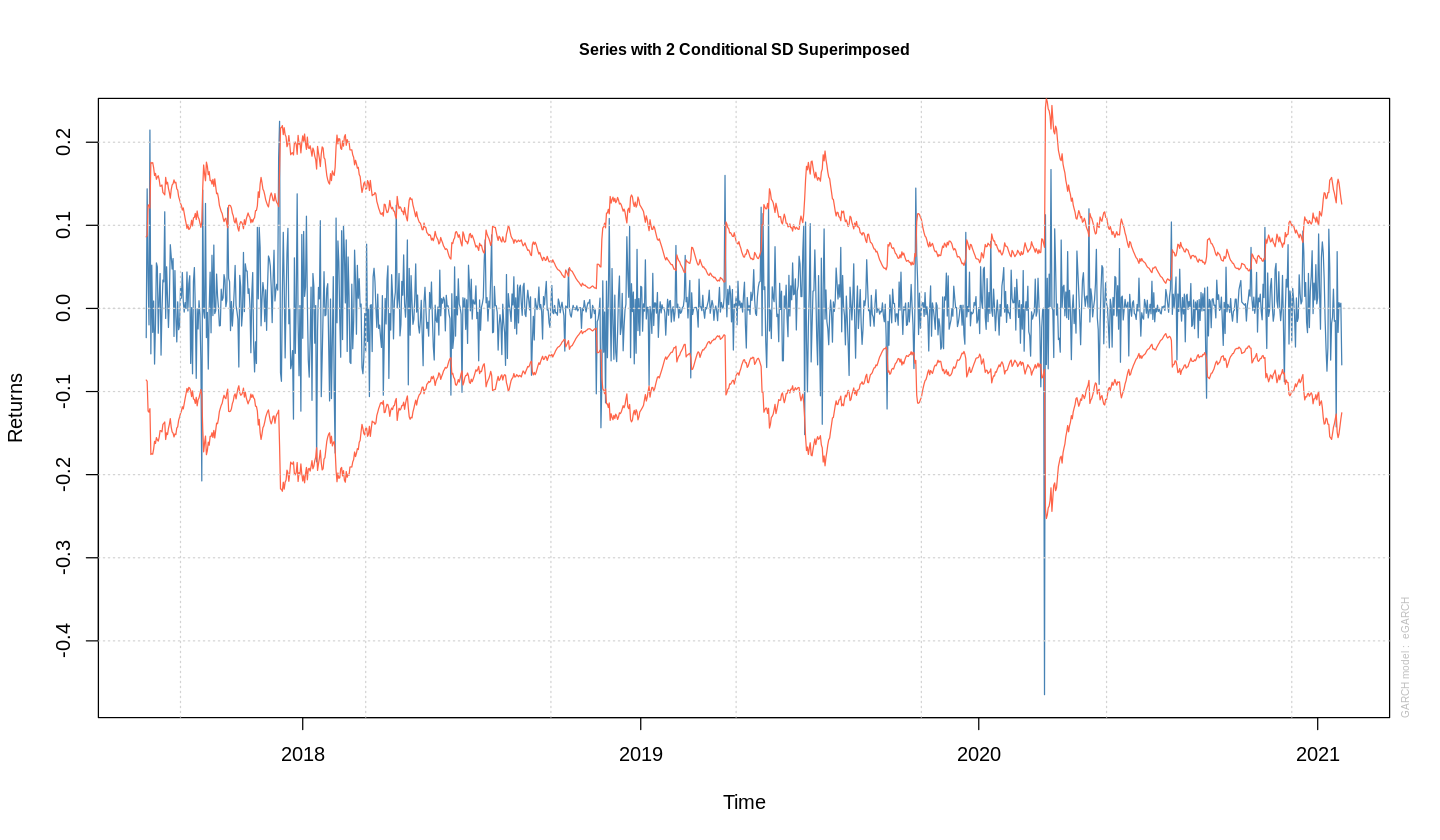

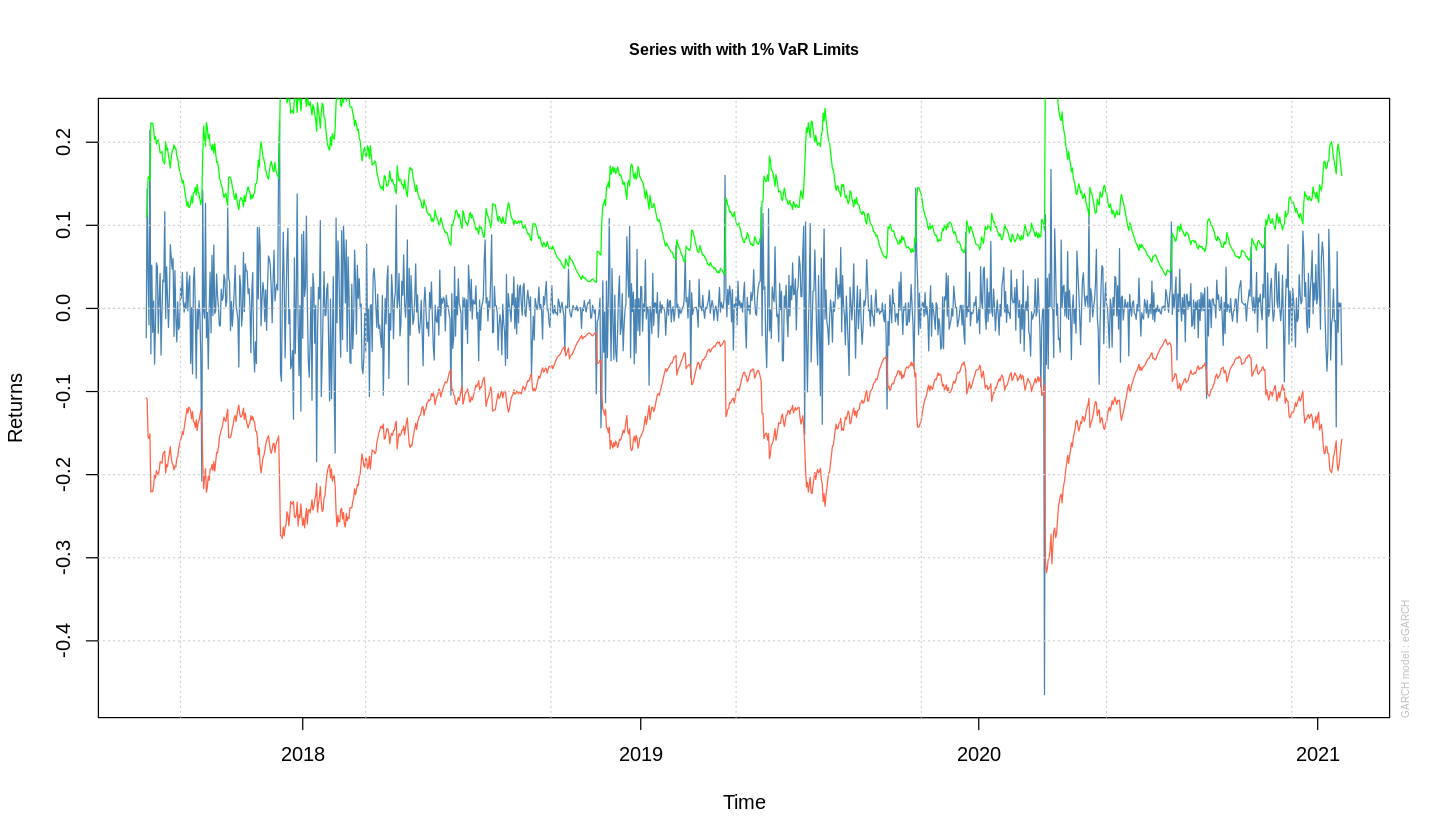

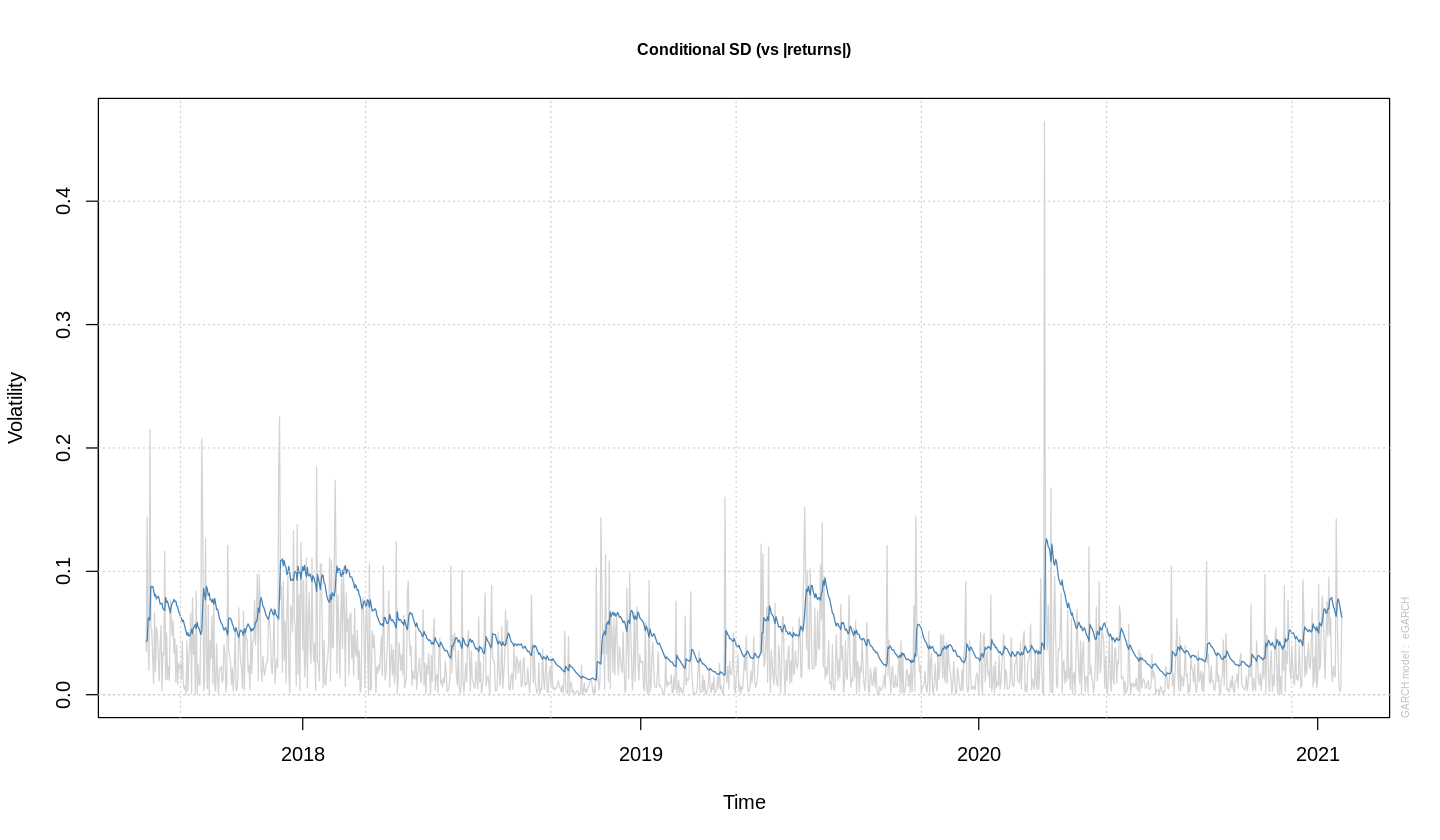

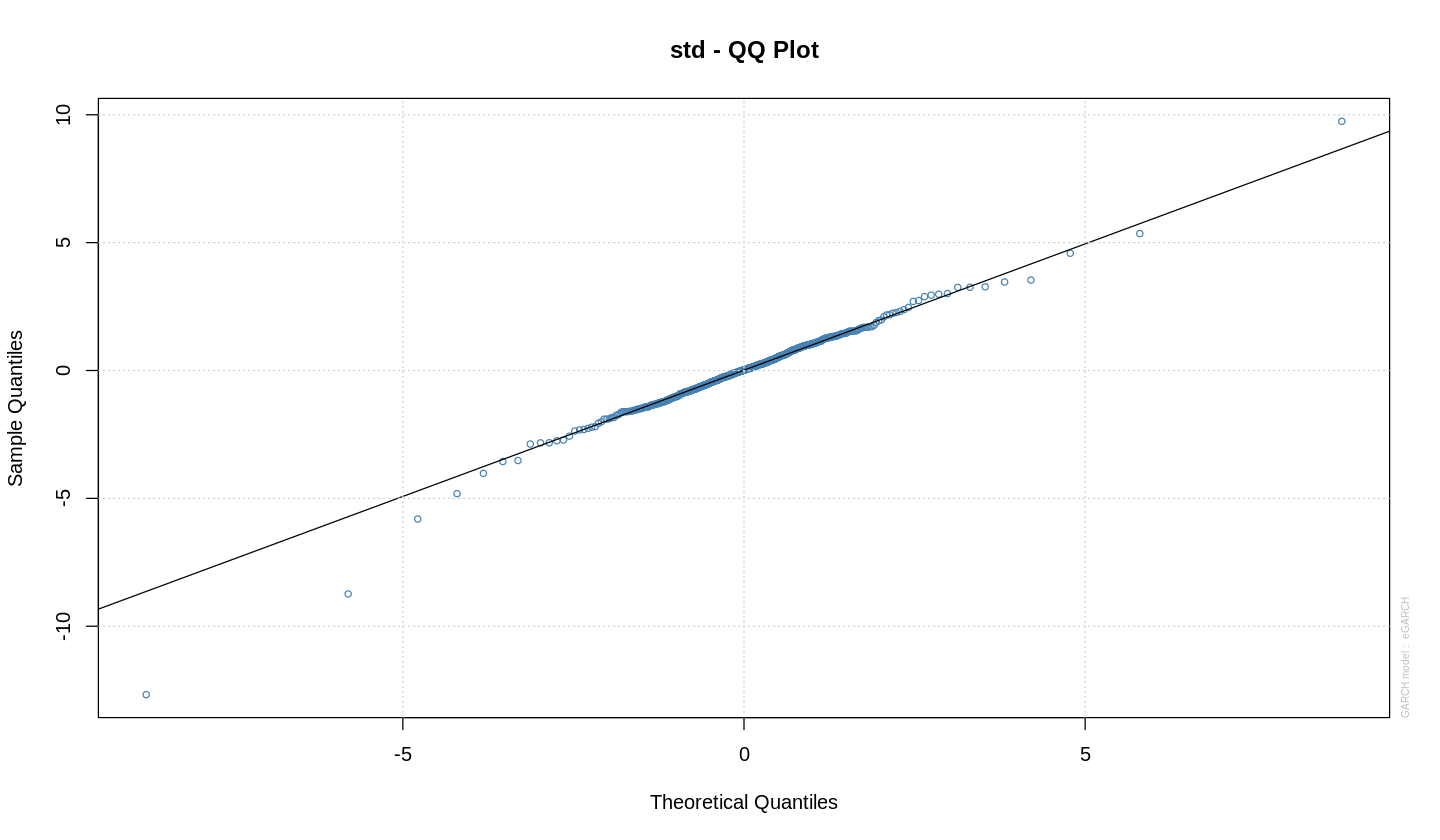

In [9]:
# el mejor modelo fue el eGARCH con distribución student-t
# se calcula el mejor modelo estimado hasta train_date

library(lubridate)

best_spec = ugarchspec(variance.model = list(model = "eGARCH", 
                                             garchOrder = c(arch_lag, garch_lag)),
                       mean.model = list(armaOrder = c(ar_lag, ma_lag)),
                       distribution = "std")


best_model <- ugarchfit(spec = best_spec, 
                           data = df_train$log_ret) 

write_rds(best_model, 'data/garch_model.rds')

best_model@model$modeldata$index = df_train$ref.date  # se igualan los ejes de tiempo para las gráficas

#opciones de ploteo
#1: Series with 2 Conditional SD Superimposed 2: Series with 1% VaR Limits 
#3: Conditional SD (vs |returns|) 4: ACF of Observations 5: ACF of Squared Observations 
#6: ACF of Absolute Observations 7: Cross Correlation 8: Empirical Density of Standardized Residuals 
#9: QQ-Plot of Standardized Residuals 10: ACF of Standardized Residuals 
#11: ACF of Squared Standardized Residuals 12: News-Impact Curve
#plot(best_model,which='all')
plot(best_model,which=1)
plot(best_model,which=2)
plot(best_model,which=3) 
plot(best_model,which=9)

# gráfica 3: la línea gris es el plot de la serie. La línea azul representa la volatilidad de la serie.
# Mirando esta gráfica se puede ver cuándo la volatilidad fue alta.

In [10]:
print(best_model)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001251    0.000428   2.9202 0.003498
omega  -0.025807    0.013749  -1.8770 0.060514
alpha1  0.026533    0.017737   1.4959 0.134680
beta1   0.995891    0.002610 381.6102 0.000000
gamma1  0.224458    0.020219  11.1013 0.000000
shape   2.694444    0.215616  12.4965 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001251    0.000306   4.0854 0.000044
omega  -0.025807    0.020077  -1.2854 0.198646
alpha1  0.026533    0.018329   1.4476 0.147726
beta1   0.995891    0.003019 329.8896 0.000000
gamma1  0.224458    0.021283  10.5461 0.000000
shape   2.694444    0.211937  12.7134 0.000000

LogLikel

##### Intepretación de los resultados
* Verificar que todos los parámetros del GARCH son significativos.
* Information Criteria: El modelo con el menor valor (AIC y BIC) es el mejor.
* Ljung Box Tests se usan para testear la autocorrealación entre los residuos y para el cuadrado de los residuos. 
* ARCH LM test: se usa para ver la presencia de efecto ARCH (Null: Adequately fitted ARCH process)

$\alpha$ y $\beta$ deben ser positivos y la suma debe ser menor que 1. Si la suma es cercana a uno, es señal de una persistencia de alta volatilidad.
Los parámetros asimétricos $\gamma$ son significativos, lo que sugiere que la volatilidad del Bitcoin es alta frente a movimientos negativos del retorno.


## 3. Proyecciones y/o validación

#### Análisis de Root Mean Squared Error (RMSE) de la varianza

In [11]:
# CÁLCULO DEL RMS DE PREDICCIÓN
# En train (in sample)
# En test (out sample)

set.seed(20200315) 

# obtención de los datos
df_prices <- read_rds('data/BTC-GARCH-Data.rds')  
# creación de datos de test
df_test <- df_prices %>% 
  filter(ref.date > train_date)
# obtención del modelo
my_model <- read_rds('data/garch_model.rds')  

# IN SAMPLE

daily_variance_train = (sigma(my_model))^2  # la varianza estimada es el cuadrado de sigma de la estimación
variance_proxy_train = (df_train$log_ret)^2  # se toma como proxy de la varianza real, los cuadrados de los retornos
mse_in  = mean((variance_proxy_train - daily_variance_train) ^ 2)
rmse_in = sqrt(mse_in)
mape_in = mean(abs(variance_proxy_train - daily_variance_train) / sqrt(variance_proxy_train))

#print(paste0('Mean Squared Error (in sample) = ', mse_in))
print(paste0('Root Mean Squared Error (in sample) = ', rmse_in))
#print(paste0('Mean Absoute Percentage Error (in sample) = ', mape_in))

# OUT SAMPLE

lag_test = days(last_date - train_date)
n_test = lag_test @ day

forecast_rugarch_sim = ugarchsim(my_model, n.sim = (n_test), m.sim = 1) # modelo simulado con test

daily_variance_test = (sigma(forecast_rugarch_sim))^2  # la varianza simulada es el cuadrado de sigma de la simulación
variance_proxy_test = (df_test$log_ret)^2  # se toma como proxy de la varianza real, los cuadrados de los retornos
mse_out  = mean((variance_proxy_test - daily_variance_test) ^ 2)
rmse_out = sqrt(mse_out)
mape_out = mean(abs(variance_proxy_test - daily_variance_test) / sqrt(variance_proxy_test))

#print(paste0('Mean Squared Error (out sample) = ', mse_out))
print(paste0('Root Mean Squared Error (out sample) = ', rmse_out))
#print(paste0('Mean Absoute Percentage Error (out sample) = ', mape_out))


[1] "Root Mean Squared Error (in sample) = 0.00745282365522153"
[1] "Root Mean Squared Error (out sample) = 0.00424488890084879"


Comparativo con resultados en [3]
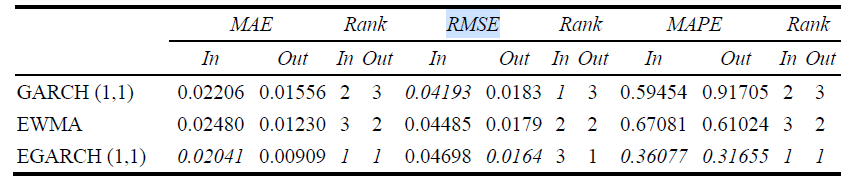

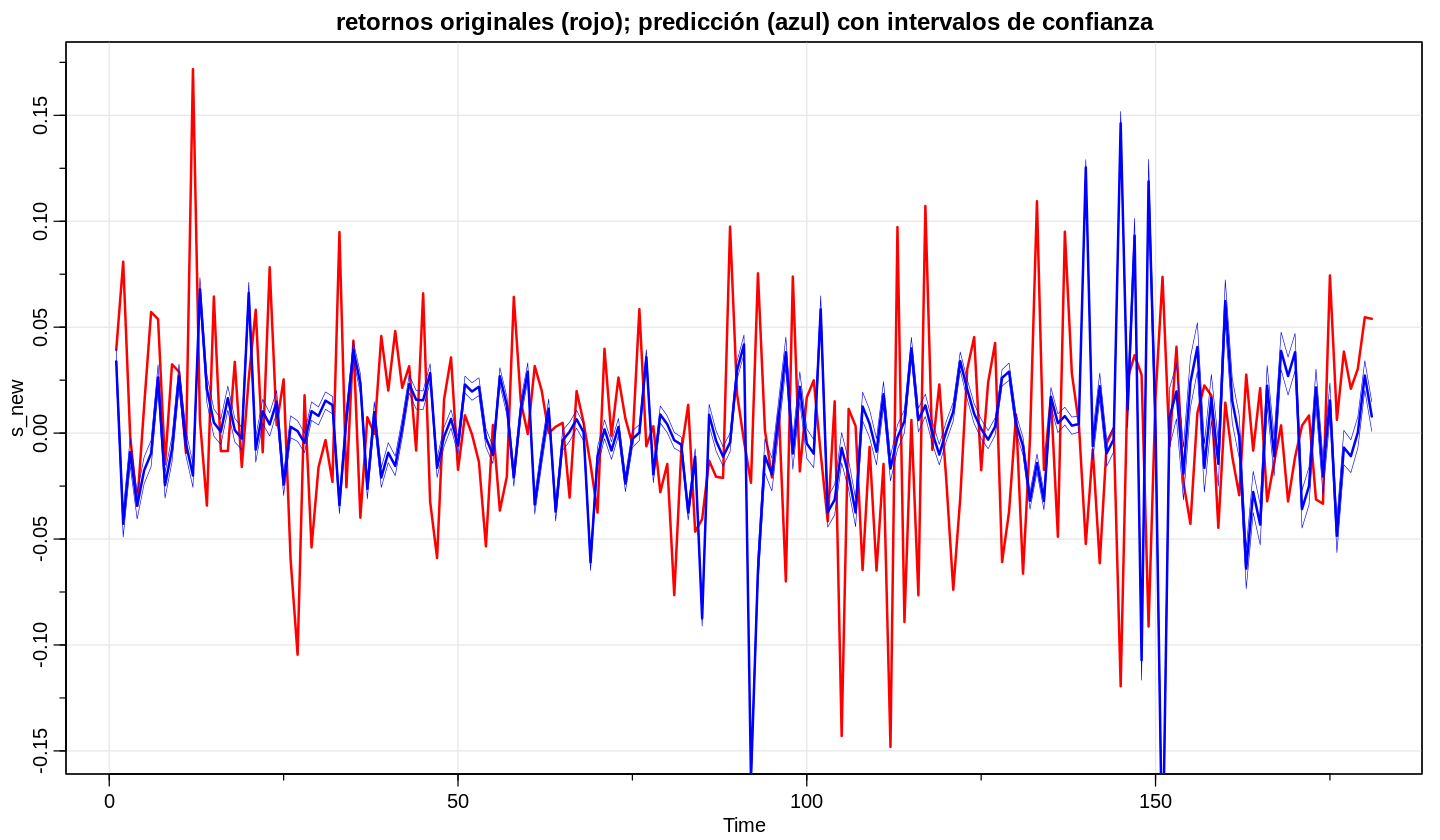

In [21]:
# Forecast con bandas de SD
library(astsa)
n = length(df_test$log_ret)
r_hat = fitted(forecast_rugarch_sim)
se = (sigma(forecast_rugarch_sim))/(sqrt(n))

s_new = df_test$log_ret
tsplot(s_new, col=2, lwd=2,  
       main = "retornos originales (rojo); predicción (azul) con intervalos de confianza")
lines(r_hat,col=4, lwd=2)
lines(r_hat+2*se,col=4, lwd=0.5)
lines(r_hat-2*se,col=4, lwd=0.5)

#### Simulación y predicción a futuro
Se realizan varias simulaciones en 2 años a futuro y se analizan las probabilidades de que el BTC alcance su máximo histórico

Rows: 548,000
Columns: 6
$ i_sim        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ i_t          <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ ref_date     <date> 2021-07-27, 2021-07-28, 2021-07-29, 2021-07-30, 2021-07…
$ sim_log_ret  <dbl> 0.0000000000, 0.0338287804, -0.0427986038, -0.0089237285…
$ sim_arit_ret <dbl> 0.0000000000, 0.0344074808, -0.0418956708, -0.0088840302…
$ sim_price    <dbl> 39406.94, 40762.83, 39055.05, 38708.08, 37402.35, 36749.…


`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 273314 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


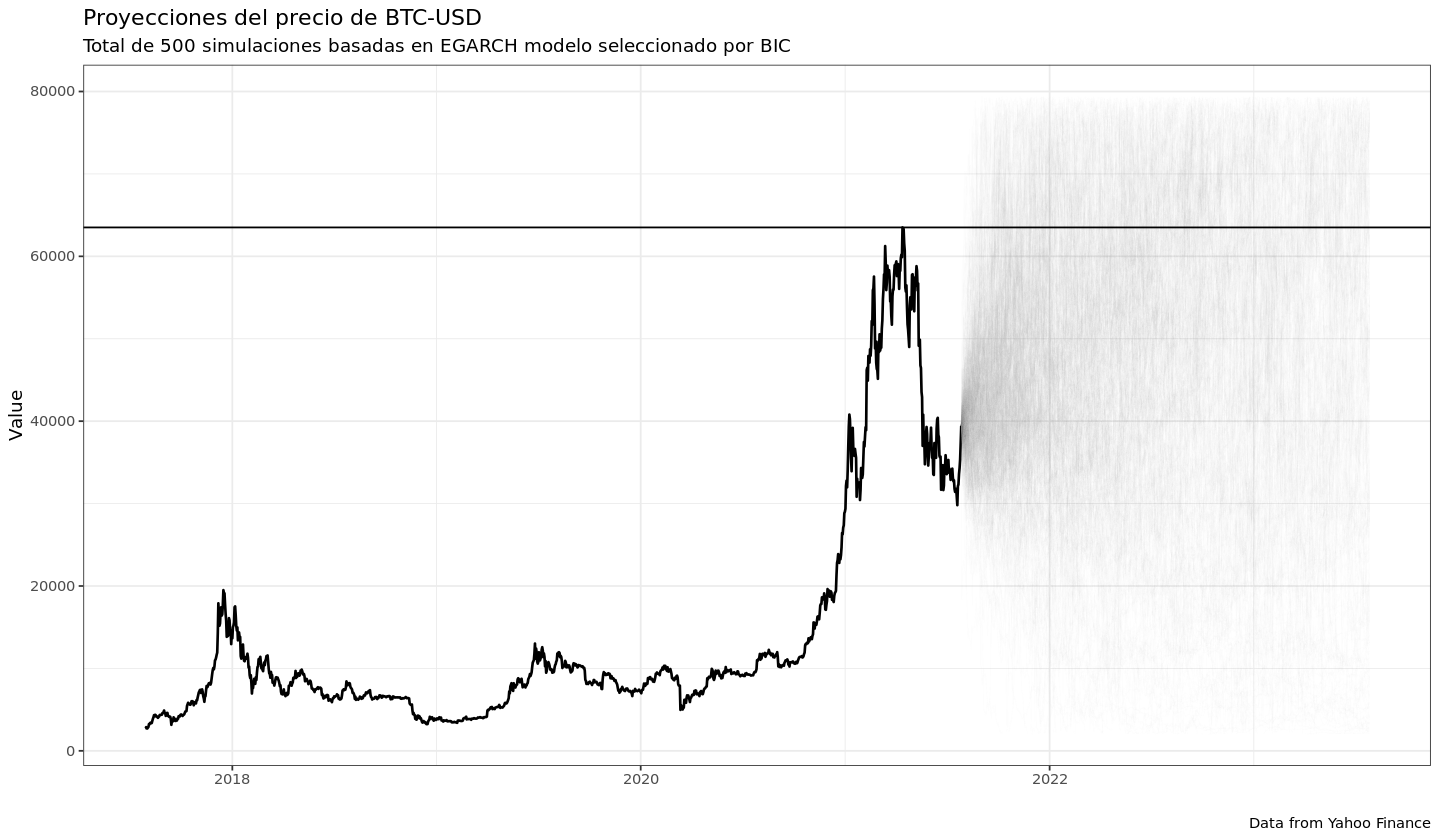

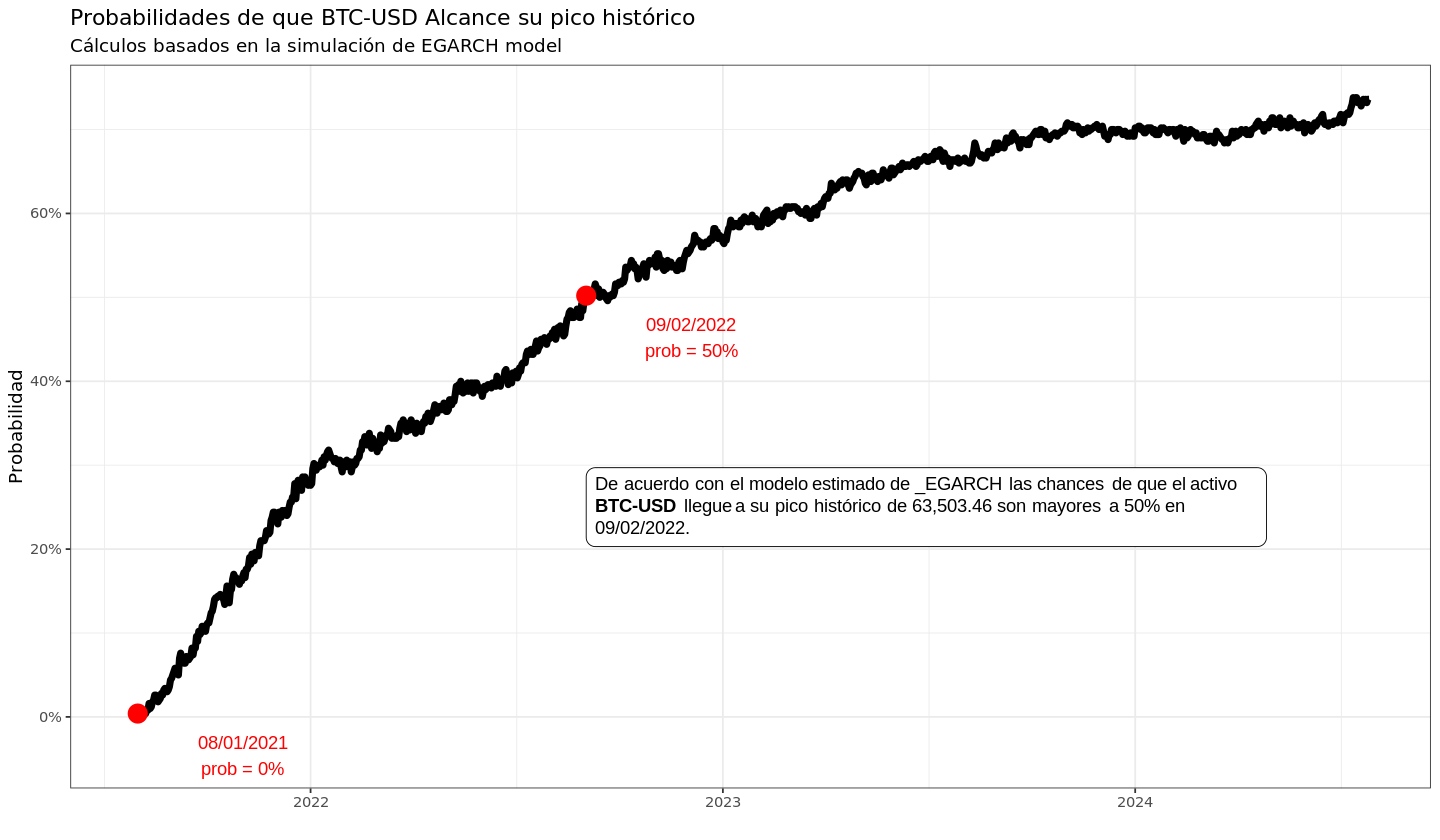

In [23]:
set.seed(20200315) # fix seed for simulations (20200315 replicates the paper's results)
n_sim <- 500 # number of simulations 
n_days_ahead <- 3*365 # Number of days ahead to simulate 

## END OPTIONS

library(tidyverse)
library(ggtext)

#graphics.off()

# get price and model data
df_prices <- read_rds('data/BTC-GARCH-Data.rds')
my_garch <- read_rds('data/garch_model.rds')
#my_garch = ugarchfit(spec = best_spec, 
 #                        data = df_prices$log_ret)  # da peor
series_name <- df_prices$series_name[1]

# source functions
source('fcts/garch_fcts.R')

# do simulations
# la función do_sim está en garch_fcts.R
df_sim <- do_sim(n_sim = n_sim, 
                 n_t = n_days_ahead, 
                 my_garch, 
                 df_prices = df_prices)

# glimpe function is like a transposed version of print: columns run down the page, and data runs across. 
glimpse(df_sim )

# calculate probabilities of reaching peak value
tab_prob <- df_sim %>%
  group_by(ref_date) %>%
  summarise(prob = mean(sim_price > max(df_prices$price.adjusted)))

n_years_back <- 4
df_prices_temp <- df_prices %>%
  dplyr::filter(ref.date > max(ref.date) - n_years_back*365)

my_garch_name <- toupper(as.character(my_garch@model$modeldesc$vmodel))

ggplot() + 
  geom_line(data = df_prices_temp, 
            aes(x = ref.date, y = price.adjusted), color = 'black', size = 0.75)  + 
  geom_line(data = df_sim, 
            aes(x = ref_date, 
                y = sim_price, 
                group = i_sim),
            color = 'grey', 
            size = 0.25,
            alpha = 0.015) + 
  theme_bw(base_family = "TT Times New Roman") + 
  geom_hline(yintercept = max(df_prices_temp$price.adjusted)) + 
  labs(title = paste0('Proyecciones del precio de ', series_name),
       subtitle = paste0('Total de ', n_sim, ' simulaciones basadas en ',
                         my_garch_name, 
                         ' modelo seleccionado por BIC'),
       caption = 'Data from Yahoo Finance',
       x = '',
       y = 'Value') + 
  ylim(c(0.75*min(df_prices_temp$price.adjusted), 
         1.25*max(df_prices_temp$price.adjusted))) + 
  xlim(c(max(df_prices_temp$ref.date) - n_years_back*365,
         max(df_prices_temp$ref.date) + 2*365) )


# probabilidad de que llegue el punto máximo
my_idx_date <- first(which(tab_prob$prob > 0.5))
df_date <- tibble(idx = c(first(which(tab_prob$prob > 0.001)),
                          first(which(tab_prob$prob > 0.5)),
                          first(which(tab_prob$prob > 0.75)),
                          first(which(tab_prob$prob > 0.95))),
                  ref_date = tab_prob$ref_date[idx],
                  prob = tab_prob$prob[idx],
                  my_text = paste0(format(ref_date, '%m/%d/%Y'),
                                   '\nprob = ', scales::percent(prob) ) )

df_textbox <- tibble(ref_date = df_date$ref_date[2],
                     prob = 0.25,
                     label = paste0('De acuerdo con el modelo estimado de _', my_garch_name,  
                                    ' las chances de que el activo **', series_name, '** llegue ',
                                    'a su pico histórico de ', 
                                    format(max(df_prices$price.adjusted), 
                                           big.mark = ',',
                                           decimal.mark = '.'),
                                    ' son mayores a 50% en ', format(ref_date, '%m/%d/%Y'), '.') )

ggplot(tab_prob, aes(x = ref_date, y = prob) ) + 
  geom_line(size = 2) + 
  labs(title = paste0('Probabilidades de que ', series_name, ' Alcance su pico histórico'),
       subtitle = paste0('Cálculos basados en la simulación de ',
                         my_garch_name, 
                         ' model'),
       x = '',
       y = 'Probabilidad') + 
  scale_y_continuous(labels = scales::percent) + 
  geom_point(data = df_date,
             aes(x = ref_date, y = prob), size = 5, color = 'red') + 
  geom_text(data = df_date, aes(x = ref_date, y = prob, 
                                label = my_text), 
            nudge_x = nrow(tab_prob)*0.085,
            nudge_y = -0.05,
            color ='red', check_overlap = TRUE) + 
  geom_textbox(data = df_textbox, 
               mapping = aes(x = ref_date, 
                             y = prob, 
                             label = label),
               width = unit(0.5, "npc"),
               #fill = "cornsilk",
               hjust = 0) + 
  theme_bw(base_family = "TT Times New Roman")

##### Forecast
Ahora se realiza la predicción en test utilizando la función forecast de rugarch (ugarchforecast)
El forecast está basado en el valor esperado de las innovaciones y por tanto de la distribución elegida.
La predicción de un paso está basada en el valor de los datos previos, mientras que la predicción "n-step ahead" está basada en la esperanza no condicional de los modelos.

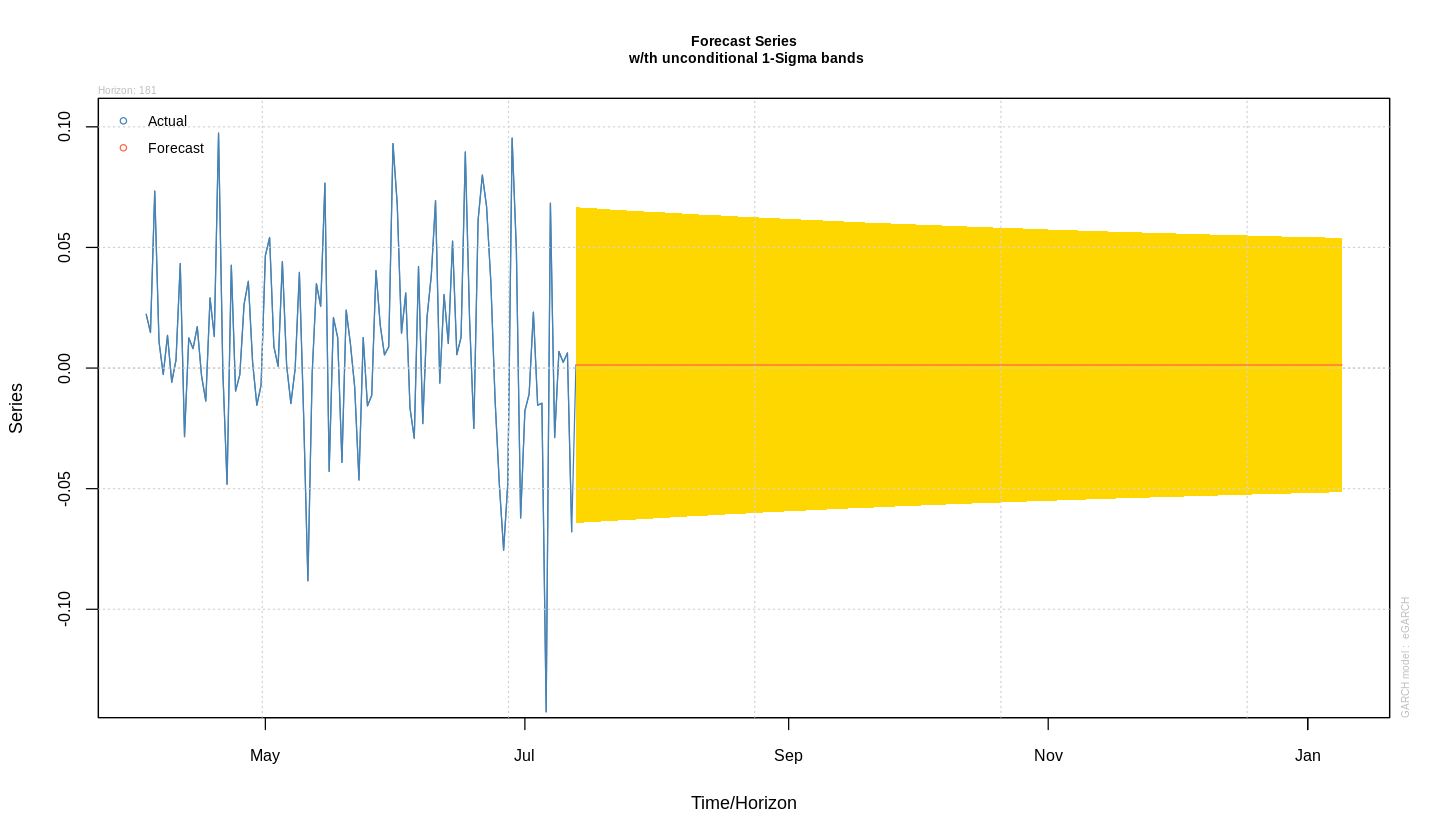

In [17]:
# predicción y test

#df_prices_train <- filter(df_prices, ref.date <= (max(ref.date)-365))                                          

df_prices <- read_rds('data/BTC-GARCH-Data.rds')

library(lubridate)
lag_test = days(last_date - train_date)
n_test = lag_test @ day # cantidad de simulaciones para el forecast (predicción a un año) 

df_test <- df_prices %>% 
  filter(ref.date > train_date)

#ajusto de nuevo el modelo con out.sample para que pueda usarse el forecast
# Indicates how many data points to keep for out of sample testing.
garch_test <- ugarchfit(spec = best_spec, 
                           data = df_prices$log_ret, out.sample = n_test) 
                                        
# A minimum of 5 data points are required for these tests. If the out.sample option is positive,
#then the routine will fit only N - out.sample (where N is the total data length) data points, leaving
#out.sample points for forecasting and testing using the forecast performance measures. 

fore = ugarchforecast(garch_test, n.ahead = n_test, n.roll = 1)
#The ability to roll the forecast 1 step at a time is implemented with the n.roll argument which
#controls how many times to roll the n.ahead forecast. The default argument of n.roll = 0 denotes
#no rolling and returns the standard n.ahead forecast. Critically, since n.roll depends on data being
#available from which to base the rolling forecast, the ugarchfit function needs to be called with the
#argument out.sample being at least as large as the n.roll argument, or in the case of a specification
#being used instead of a fit object, the out.sample argument directly in the forecast function.
#n.ahead: The forecast horizon.
#n.roll: The no. of rolling forecasts to create beyond the first one (see details).


#fore@model$modeldata$index = df_test$ref.date  # se igualan los ejes de tiempo para las gráficas

plot(fore, which= 1) 

In [ ]:
str(df_test$ref.date)


#### Referencias
[1] A GARCH Tutorial with R
https://github.com/msperlin/GARCH-RAC
[2] Modelling the volatility of Bitcoin returns using GARCH models (Samuel Asante Gyamerah)
[3] Modelling and predicting the Bitcoin volatility using GARCH models. https://www.researchgate.net/publication/322261567_Modelling_and_predicting_the_Bitcoin_volatility_using_GARCH_models